# Extracting Medical Concepts from Textual Data

## Workspace set up: Import and Install useful packages.

### Implementation of a Custom Named Entity Recognition (NER) System for Medical Data

This notebook presents the development of a custom Named Entity Recognition (NER) system aimed at identifying diseases and treatments within a medical dataset. The dataset is provided as token-level annotations, with each word assigned a specific label:

- `O`: Represents "Other"
- `D`: Denotes "Disease"
- `T`: Signifies "Treatment"

### Methodological Steps

1. **Data Reconstruction**: Reassemble sentences and their corresponding labels from the tokenized dataset to facilitate comprehensive analysis.
2. **Conceptual Analysis**: Employ Part-of-Speech (PoS) tagging techniques to identify and categorize key concepts within the dataset.
3. **Feature Engineering for CRF**: Develop and define features essential for training the Conditional Random Field (CRF) model, ensuring they capture context and structure of each token effectively.
4. **Feature Application**: Systematically apply the defined features across all sentences in the dataset to prepare for model training.
5. **Dataset Preparation**: Organize and partition the dataset into input features and target labels, establishing distinct training and testing subsets.
6. **Model Development**: Utilize the training dataset to construct and train the CRF model, optimizing it for accurate entity recognition.
7. **Performance Evaluation**: Assess the model's effectiveness on the test dataset, employing metrics such as the F1 score and other pertinent classification metrics.
8. **Entity Extraction**: Leverage the trained model to identify and extract relationships between diseases and treatments, enhancing the dataset's utility for medical analysis.
e trained model.
e trained model.
e trained model.


In [5]:
%pip install pycrf
%pip install sklearn-crfsuite
%pip install pandas
%pip install nltk
%pip install spacy

import numpy as np

import sklearn_crfsuite
from sklearn_crfsuite import metrics

from nltk import FreqDist

import spacy
spacy.cli.download("en_core_web_sm")

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

model = spacy.load("en_core_web_sm")


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 24.4 MB/s eta 0:00:0000:01


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

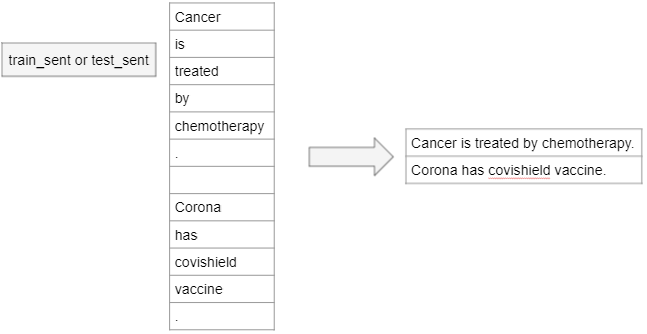

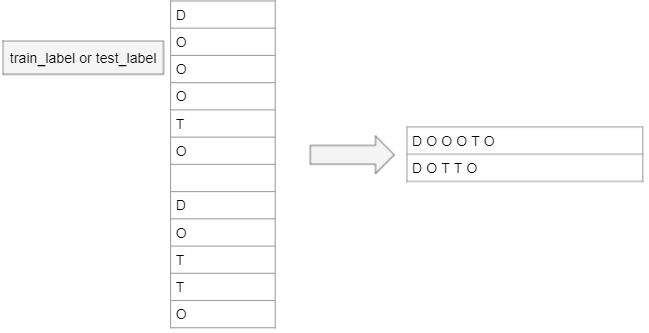

In [6]:
def preprocess_inputinput_stream(input_input_streampath):
    with open(input_input_streampath, "r") as input_stream:
        sentence_collection = []
        current_sentence = []

        for text_line in input_stream:
            token = text_line.strip()
            if token:
                current_sentence.append(token)
            else:
                if current_sentence:
                    sentence_collection.append(" ".join(current_sentence))
                    current_sentence = []

        # Add the last sentence if the input_stream doesn't end with a blank text_line
        if current_sentence:
            sentence_collection.append(" ".join(current_sentence))

    return sentence_collection


In [7]:
# loading and processing train data
training_sentences=preprocess_inputinput_stream(input_input_streampath="/Users/hemalpatel/Downloads/NLP_Syntactic_Processing-main/train_sent")
training_labels=preprocess_inputinput_stream(input_input_streampath="/Users/hemalpatel/Downloads/NLP_Syntactic_Processing-main/train_label")

#loading and processing test data
testing_sentences=preprocess_inputinput_stream(input_input_streampath="/Users/hemalpatel/Downloads/NLP_Syntactic_Processing-main/test_sent")
testing_labels=preprocess_inputinput_stream(input_input_streampath="/Users/hemalpatel/Downloads/NLP_Syntactic_Processing-main/test_label")

In [8]:
# Display sample training sentences and their labels
print("Sample training sentences and their labels:")
print('-' * 100)

for i, (sentence, label) in enumerate(zip(training_sentences[:5], training_labels[:5]), 1):
    print(f"Sentence {i}: {sentence}")
    print(f"Label {i}: {label}")
    print('-' * 100)


Sample training sentences and their labels:
----------------------------------------------------------------------------------------------------
Sentence 1: All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
Label 1: O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
----------------------------------------------------------------------------------------------------
Sentence 2: The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Label 2: O O O O O O O O O O O O O O O O O O O O O O O O O
----------------------------------------------------------------------------------------------------
Sentence 3: Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
Label 3: O O O O O O O O O O O O O O O
-----------

In [9]:
# Display sample training sentences and their labels
print("Sample test sentences and their labels:")
print('-' * 100)

for i, (sentence, label) in enumerate(zip(testing_sentences[:5], testing_labels[:5]), 1):
    print(f"Sentence {i}: {sentence}")
    print(f"Label {i}: {label}")
    print('-' * 100)


Sample test sentences and their labels:
----------------------------------------------------------------------------------------------------
Sentence 1: Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )
Label 1: O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
----------------------------------------------------------------------------------------------------
Sentence 2: As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration
Label 2: O O O O O O O O O O O O O O O O O O O
----------------------------------------------------------------------------------------------------
Sentence 3: The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period
Label 3: O O O O O O O O O O

### Count the number of sentences in the processed train and test dataset 

In [10]:
print("Number of sentences in the processed train set:",len(training_sentences))
print('-' * 70)
print("Number of sentences in the processed test set:",len(testing_sentences))
print('-' * 70)

Number of sentences in the processed train set: 2599
----------------------------------------------------------------------
Number of sentences in the processed test set: 1056
----------------------------------------------------------------------


### Count the number of lines of labels in the processed train and test dataset.

In [11]:
print("Number of sentences in the processed train set:",len(training_labels))
print('-' * 70)
print("Number of sentences in the processed test set:",len(testing_labels))
print('-' * 70)

Number of sentences in the processed train set: 2599
----------------------------------------------------------------------
Number of sentences in the processed test set: 1056
----------------------------------------------------------------------


#### Lengths of sentences and labels for train and test set match. The preprocessing is done properly.

## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [12]:
all_sentences = training_sentences + testing_sentences

noun_propn_tokens=[]
for sentence in all_sentences:
    processed_sentence = model(sentence)
    for token in processed_sentence:
        if token.pos_ in ('NOUN','PROPN'):
            noun_propn_tokens.append(token.text)

# Display the first 5 noun and proper noun tokens
for i in range(min(5, len(noun_propn_tokens))):
    print(f"Token {i + 1}: {noun_propn_tokens[i]}")

Token 1: births
Token 2: =
Token 3: weeks
Token 4: University
Token 5: Vermont


In [13]:
print("Total number of nouns and proper nouns in given data set:", len(noun_propn_tokens) )

Total number of nouns and proper nouns in given data set: 24373


### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [14]:
frequency=FreqDist(noun_propn_tokens)
noun_propn_tokens_df=pd.DataFrame(frequency.most_common(25) , columns=["Tokens","count"])
noun_propn_tokens_df

,Tokens,count
0,patients,492
1,treatment,281
2,%,247
3,cancer,200
4,therapy,175
5,study,153
6,disease,141
7,cell,140
8,lung,116
9,group,94


## Defining features for CRF





### Model 1:

# Feature Definitions for Word Processing

## Word-Level Features

- **f1:** Indicates whether the word is in lowercase.
- **f2:** Extracts the last three characters of the word.
- **f3:** Extracts the last two characters of the word.
- **f4:** Assigns a value of 1 if the word is in uppercase; otherwise, assigns 0.
- **f5:** Assigns a value of 1 if the word is numeric; otherwise, assigns 0.
- **f6:** Assigns a value of 1 if the word starts with a capital letter; otherwise, assigns 0.
- **f7:** Denotes the part-of-speech (POS) tag of the word within the sentence.

## Previous Word Features

*Applicable to all words except the first in a sentence:*

- **f8:** Provides the previous word in lowercase.
- **f9:** Assigns a value of 1 if the previous word is in uppercase; otherwise, assigns 0.
- **f10:** Assigns a value of 1 if the previous word is numeric; otherwise, assigns 0.
- **f11:** Assigns a value of 1 if the previous word starts with a capital letter; otherwise, assigns 0.
- **f12:** Denotes the POS tag of the previous word within the sentence.

## Sentence Boundary Features

- **f13:** Marks the beginning of a sentence with a special token, such as "BEG."
- **f14:** Marks the end of a sentence with a special token, such as "END."


## Defining features for CRF

In [15]:
def get_features_for_one_token(sentence, pos, postags):
    """
    Extracts features for a specific token in a sentence.

    Args:
        sentence (list): The list of tokens in the sentence.
        pos (int): The position of the token in the sentence.
        postags (list): The list of POS tags corresponding to each token in the sentence.

    Returns:
        list: A list of features for the specified token.
    """
    token = sentence[pos]
    features = [
        f'token.lower={token.lower()}',  # Word in lowercase
        f'token[-3:]={token[-3:]}',       # Last three characters
        f'token[-2:]={token[-2:]}',       # Last two characters
        f'token.isupper={token.isupper()}',  # Is the token in uppercase
        f'token.isdigit={token.isdigit()}',  # Is the token a number
        f'token.startswithcapital={token[0].isupper()}',  # Starts with a capital letter
        f'token.pos={postags[pos]}'  # POS tag of the token
    ]
    
    # Use the previous token also while defining features
    if pos > 0:
        prev_token = sentence[pos - 1]
        features.extend([
            f'prev_token.lower={prev_token.lower()}',
            f'prev_token.isupper={prev_token.isupper()}',
            f'prev_token.isdigit={prev_token.isdigit()}',
            f'prev_token.startswithcapital={prev_token[0].isupper()}',
            f'prev_token.pos={postags[pos - 1]}'  # POS tag of the previous token
        ])
        
    # Mark the beginning and the end tokens of a sentence correctly in the form of features
    else:
        features.append('BEG')  # Feature to track beginning of sentence
    if pos == len(sentence) - 1:
        features.append('END')  # Feature to track end of sentence

    return features


## Getting the features

### Write a code/function to get the features for a sentence

In [16]:
# Write a code to get features for a sentence.

def get_features_for_sentence(sentence):
    """
    Extracts features for each token in a sentence.

    Args:
        sentence (str): The input sentence from which features are to be extracted.

    Returns:
        list: A list of lists, each containing features for a token in the sentence.
    """
    # Process the sentence using the spaCy model
    preprocessed_sent = model(sentence)
    
    # Extract part-of-speech tags for each token
    postags = [token.pos_ for token in preprocessed_sent]
    
    # Split the sentence into a list of tokens
    sentence_list = sentence.split()
    
    # Extract features for each token
    features_sent = [
        get_features_for_one_token(sentence_list, pos, postags)
        for pos in range(len(sentence_list))
    ]
    return features_sent


### Write a code/function to get the labels of a sentence

In [17]:
# Write a code to get the labels for a sentence.

def get_Labels_For_One_Sentence(labels):
    labels_sent = labels.split()
    return labels_sent

sample_sent=training_sentences[1]
print(sample_sent)

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


In [18]:
print(get_features_for_sentence(sample_sent))

[['token.lower=the', 'token[-3:]=The', 'token[-2:]=he', 'token.isupper=False', 'token.isdigit=False', 'token.startswithcapital=True', 'token.pos=DET', 'BEG'], ['token.lower=total', 'token[-3:]=tal', 'token[-2:]=al', 'token.isupper=False', 'token.isdigit=False', 'token.startswithcapital=False', 'token.pos=ADJ', 'prev_token.lower=the', 'prev_token.isupper=False', 'prev_token.isdigit=False', 'prev_token.startswithcapital=True', 'prev_token.pos=DET'], ['token.lower=cesarean', 'token[-3:]=ean', 'token[-2:]=an', 'token.isupper=False', 'token.isdigit=False', 'token.startswithcapital=False', 'token.pos=ADJ', 'prev_token.lower=total', 'prev_token.isupper=False', 'prev_token.isdigit=False', 'prev_token.startswithcapital=False', 'prev_token.pos=ADJ'], ['token.lower=rate', 'token[-3:]=ate', 'token[-2:]=te', 'token.isupper=False', 'token.isdigit=False', 'token.startswithcapital=False', 'token.pos=NOUN', 'prev_token.lower=cesarean', 'prev_token.isupper=False', 'prev_token.isdigit=False', 'prev_token

In [19]:
# check label functions
sample_label=training_labels[1]
print(get_Labels_For_One_Sentence(sample_label))

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [20]:
X_train=[ get_features_for_sentence(sent) for sent in training_sentences ]
X_test=[ get_features_for_sentence(sent) for sent in testing_sentences ]

### Define the labels as the target variable for test and the train dataset

In [21]:
y_train=[ get_Labels_For_One_Sentence(sent) for sent in training_labels ]
y_test=[ get_Labels_For_One_Sentence(sent) for sent in testing_labels ]

## Build the CRF Model

In [22]:
# Build the CRF model.
crf=sklearn_crfsuite.CRF(max_iterations=100)

In [23]:
try :
    crf.fit(X_train,y_train)
except AttributeError:
    print(f"AttributeError encountered: {e}")

In [24]:
# Access the feature weights using the CRF instance
feature_weights = crf.state_features_

# Sort and display top weights
sorted_features = sorted(feature_weights.items(), key=lambda x: x[1], reverse=True)
for feature, weight in sorted_features[:10]:  # Top 10 features
    print(f"Feature: {feature}, Weight: {weight}")


Feature: ('token.lower=infection', 'D'), Weight: 2.54688
Feature: ('token.lower=for', 'O'), Weight: 2.490423
Feature: ('token[-3:]=for', 'O'), Weight: 2.454856
Feature: ('token.lower=disease', 'D'), Weight: 1.956402
Feature: ('token.lower=resection', 'T'), Weight: 1.912161
Feature: ('token[-3:]=tis', 'D'), Weight: 1.902906
Feature: ('token[-2:]=ia', 'D'), Weight: 1.887626
Feature: ('token.lower=diabetes', 'D'), Weight: 1.863135
Feature: ('token.lower=tumors', 'D'), Weight: 1.775311
Feature: ('token[-2:]=lc', 'D'), Weight: 1.768921


In [25]:
crf_state_weight_list=list(map( lambda x: round(float(x[1]),3) , list(crf.state_features_.items()) ))
crf_state_feature_list=list(map( lambda x: x[0] , list(crf.state_features_.items()) ))
crf_state_features_df=pd.DataFrame({
    "Features":crf_state_feature_list,
    "Weight":crf_state_weight_list
})
print(crf_state_features_df.shape)

(22640, 2)


In [26]:
crf_state_features_df.sort_values(by="Weight" , ascending=False).head(20)

,Features,Weight
3999,"(token.lower=infection, D)",2.547
262,"(token.lower=for, O)",2.490
264,"(token[-3:]=for, O)",2.455
2400,"(token.lower=disease, D)",1.956
14852,"(token.lower=resection, T)",1.912
3801,"(token[-3:]=tis, D)",1.903
1517,"(token[-2:]=ia, D)",1.888
1095,"(token.lower=diabetes, D)",1.863
3188,"(token.lower=tumors, D)",1.775
19132,"(token[-2:]=lc, D)",1.769


In [27]:
crf_state_features_df.sort_values(by="Weight" , ascending=False).tail(20)

,Features,Weight
1518,"(token[-2:]=ia, T)",-1.210
2244,"(token[-3:]=rin, O)",-1.219
12769,"(token[-3:]=tin, O)",-1.220
2056,"(token.lower=surgery, O)",-1.222
1330,"(token[-3:]=ain, T)",-1.227
5221,"(token[-3:]=cin, O)",-1.247
19141,"(token[-3:]=clc, O)",-1.256
1460,"(token[-3:]=omy, O)",-1.260
5407,"(token.lower=surgical, O)",-1.281
5410,"(prev_token.lower=surgical, O)",-1.286


In [28]:
# Access the transition weights
transition_features = crf.transition_features_

# Sort and display top transitions
sorted_transitions = sorted(transition_features.items(), key=lambda x: x[1], reverse=True)
for transition, weight in sorted_transitions[:10]:  # Top 10 transitions
    print(f"Transition: {transition}, Weight: {weight}")

Transition: ('D', 'D'), Weight: 4.680396
Transition: ('T', 'T'), Weight: 4.162783
Transition: ('O', 'D'), Weight: 1.633726
Transition: ('O', 'O'), Weight: 1.246788
Transition: ('T', 'O'), Weight: 1.108242
Transition: ('D', 'O'), Weight: -1.62084
Transition: ('O', 'T'), Weight: -1.854033
Transition: ('D', 'T'), Weight: -2.347379


## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [29]:
y_pred=crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [30]:
f1_score=metrics.flat_f1_score(y_test,y_pred,average="weighted")
print(f"F1 score is: {round(f1_score,3)}")

F1 score is: 0.907


## Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

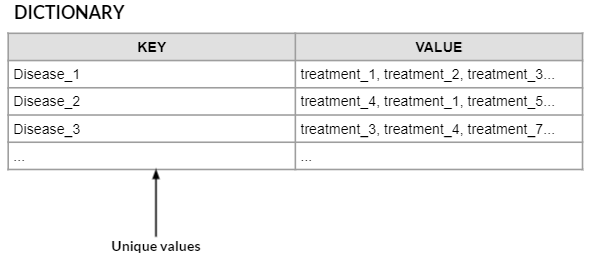

In [31]:
# Initialize an empty dictionary to map diseases to their corresponding treatments
disease_to_treatment_map = {}

for i in range(len(y_pred)):
    # Retrieve the predicted labels for the current test sentence
    predicted_labels = y_pred[i]

    # Initialize strings to accumulate diseases and treatments
    diseases = ""
    treatments = ""

    # Iterate through the labels to identify and concatenate diseases and treatments
    for j in range(len(predicted_labels)):
        if predicted_labels[j] == 'D':  # 'D' denotes a Disease
            diseases += testing_sentences[i].split()[j] + " "
        elif predicted_labels[j] == 'T':  # 'T' denotes a Treatment
            treatments += testing_sentences[i].split()[j] + " "

    # Remove leading and trailing whitespace
    diseases = diseases.strip()
    treatments = treatments.strip()

    # If both diseases and treatments are identified, update the dictionary
    if diseases and treatments:
        if diseases in disease_to_treatment_map:
            # Append new treatments to existing ones
            disease_to_treatment_map[diseases] += " , " + treatments
        else:
            # Add a new entry for the disease
            disease_to_treatment_map[diseases] = treatments


In [32]:
D_T_dataframe=pd.DataFrame({
    "KEY": list(disease_to_treatment_map.keys()) ,
    "VALUE" : list(disease_to_treatment_map.values())
})
D_T_dataframe

,KEY,VALUE
0,hereditary retinoblastoma,radiotherapy
1,myocardial infarction,"warfarin with 80 mg aspirin , or 1 mg warfarin with 80 mg aspirin"
2,unstable angina or non-Q-wave myocardial infarction,roxithromycin
3,coronary-artery disease,Antichlamydial antibiotics
4,primary pulmonary hypertension ( PPH ),fenfluramines
5,essential hypertension,moxonidine
6,foot infection,G-CSF treatment
7,early Parkinson 's disease,Ropinirole monotherapy
8,abdominal tuberculosis,steroids
9,female stress urinary incontinence,surgical treatment


In [33]:
D_T_dataframe.shape

(110, 2)

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [34]:
disease = 'hereditary retinoblastoma'

In [35]:
print(f"The treatment for {disease} is {disease_to_treatment_map[disease]}")

The treatment for hereditary retinoblastoma is radiotherapy


In [36]:
D_T_dataframe.loc[(D_T_dataframe.KEY == disease), ["KEY", "VALUE"]]

,KEY,VALUE
0,hereditary retinoblastoma,radiotherapy


## Model 2

### List of Features

- **Features for Each Word in a Sentence:**
    - **f1:** Indicates whether the word is in lowercase.
    - **f2:** Last three characters of the word.
    - **f3:** Last two characters of the word.
    - **f4:** `1` if the word is in uppercase; otherwise, `0`.
    - **f5:** `1` if the word is a number; otherwise, `0`.
    - **f6:** `1` if the word starts with a capital letter; otherwise, `0`.
    - **f7:** Part-of-speech (POS) tag of the word.
    - **f8:** Dependency parsing tag of the word.

- **Features Considering the Previous Word (Except the First Word):**
    - **f9:** Previous word in lowercase.
    - **f10:** `1` if the previous word is uppercase; otherwise, `0`.
    - **f11:** `1` if the previous word is a number; otherwise, `0`.
    - **f12:** `1` if the previous word starts with a capital letter; otherwise, `0`.
    - **f13:** POS tag of the previous word.
    - **f14:** Dependency parsing tag of the previous word.

- **Features to Track the Beginning and End of a Sentence:**
    - **f15:** `BEG` to mark the beginning of a sentence.
    - **f16:** `END` to mark the end of a sentence.


In [37]:
def get_features_for_token(sentence, pos, postags, deptags):
    """
    Extracts features for a specific token in a sentence.

    Args:
        sentence (list): The list of tokens in the sentence.
        pos (int): The position (index) of the token in the sentence.
        postags (list): List of part-of-speech tags corresponding to each token.
        deptags (list): List of dependency parsing tags corresponding to each token.

    Returns:
        list: A list of features for the specified token.
    """
    token = sentence[pos]
    features = [
        f'token.lower={token.lower()}',  # Word in lowercase
        f'token[-3:]={token[-3:]}',      # Last three characters
        f'token[-2:]={token[-2:]}',      # Last two characters
        f'token.isupper={int(token.isupper())}',  # Is the token in uppercase
        f'token.isdigit={int(token.isdigit())}',  # Is the token a number
        f'token.starts_with_capital={int(token[0].isupper())}',  # Starts with a capital letter
        f'token.pos={postags[pos]}',     # Part-of-speech tag
        f'token.dep_={deptags[pos]}'     # Dependency parsing tag
    ]
    # Include features from the previous token, if not the first token
    if pos > 0:
        prev_token = sentence[pos - 1]
        features.extend([
            f'prev_token.lower={prev_token.lower()}',
            f'prev_token.isupper={int(prev_token.isupper())}',
            f'prev_token.isdigit={int(prev_token.isdigit())}',
            f'prev_token.starts_with_capital={int(prev_token[0].isupper())}',
            f'prev_token.pos={postags[pos - 1]}',  # POS tag of previous token
            f'prev_token.dep_={deptags[pos - 1]}'   # Dependency tag of previous token
        ])
    else:
        features.append('BEG')  # Mark the beginning of the sentence
    # Mark the end of the sentence for the last token
    if pos == len(sentence) - 1:
        features.append('END')  # Mark the end of the sentence
    return features


## Getting the features

### Write a code/function to get the features for a sentence

In [38]:
def get_features_for_sentence(sentence):
    """
    Extracts features for each token in a sentence using a pre-trained model.

    Args:
        sentence (str): The input sentence from which features are to be extracted.

    Returns:
        list: A list of feature sets, each corresponding to a token in the sentence.
    """
    # Process the sentence using the pre-trained model
    preprocessed_sentence = model(sentence)
    
    # Extract part-of-speech tags and dependency tags
    pos_tags = [token.pos_ for token in preprocessed_sentence]
    dep_tags = [token.dep_ for token in preprocessed_sentence]
    
    # Split the sentence into individual tokens
    sentence_tokens = sentence.split()
    
    # Extract features for each token
    features_sentence = [
        get_features_for_token(sentence_tokens, index, pos_tags, dep_tags)
        for index in range(len(sentence_tokens))
    ]
    
    return features_sentence


### Write a code/function to get the labels of a sentence

In [39]:
def get_labels_for_sentence(labels):
    # Split the labels string into a list of labels
    labels_list = labels.split()
    return labels_list


## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [40]:
X_train=[ get_features_for_sentence(sent) for sent in training_sentences ]
X_test=[ get_features_for_sentence(sent) for sent in testing_sentences ]

### Define the labels as the target variable for test and the train dataset

In [41]:
y_train=[ get_labels_for_sentence(sent) for sent in training_labels ]
y_test=[ get_labels_for_sentence(sent) for sent in testing_labels ]

## Build the CRF Model

In [42]:
# Build the CRF model.
crf=sklearn_crfsuite.CRF(max_iterations=100)

In [43]:
try :
    crf.fit(X_train,y_train)
except AttributeError:
    print(f"AttributeError encountered: {e}")

In [44]:
# Access the feature weights using the CRF instance
feature_weights = crf.state_features_

# Sort and display top weights
sorted_features = sorted(feature_weights.items(), key=lambda x: x[1], reverse=True)
for feature, weight in sorted_features[:20]:  # Top 10 features
    print(f"Feature: {feature}, Weight: {weight}")


Feature: ('token.lower=infection', 'D'), Weight: 1.962816
Feature: ('token.lower=for', 'O'), Weight: 1.802483
Feature: ('token[-2:]=ia', 'D'), Weight: 1.77369
Feature: ('token[-3:]=for', 'O'), Weight: 1.766619
Feature: ('token.lower=disease', 'D'), Weight: 1.514695
Feature: ('token.lower=resection', 'T'), Weight: 1.488862
Feature: ('token.lower=diabetes', 'D'), Weight: 1.482925
Feature: ('token.lower=tumors', 'D'), Weight: 1.457014
Feature: ('token[-3:]=tis', 'D'), Weight: 1.380785
Feature: ('token.lower=syndrome', 'D'), Weight: 1.34441
Feature: ('token.lower=patients', 'O'), Weight: 1.34136
Feature: ('token[-2:]=ma', 'D'), Weight: 1.309612
Feature: ('token.lower=in', 'O'), Weight: 1.28424
Feature: ('token[-3:]=cer', 'D'), Weight: 1.273583
Feature: ('token[-3:]=sty', 'T'), Weight: 1.270475
Feature: ('token[-2:]=py', 'T'), Weight: 1.24079
Feature: ('token[-2:]=lc', 'D'), Weight: 1.226558
Feature: ('token.lower=vaccine', 'T'), Weight: 1.224759
Feature: ('token[-3:]=apy', 'T'), Weight: 1.

In [45]:
crf_state_weight_list=list(map( lambda x: round(float(x[1]),3) , list(crf.state_features_.items()) ))
crf_state_feature_list=list(map( lambda x: x[0] , list(crf.state_features_.items()) ))
crf_state_features_df=pd.DataFrame({
    "Features":crf_state_feature_list,
    "Weight":crf_state_weight_list
})
print(crf_state_features_df.shape)

(22875, 2)


In [46]:
crf_state_features_df.sort_values(by="Weight" , ascending=False).head(20)

,Features,Weight
4218,"(token.lower=infection, D)",1.963
342,"(token.lower=for, O)",1.802
1703,"(token[-2:]=ia, D)",1.774
344,"(token[-3:]=for, O)",1.767
2597,"(token.lower=disease, D)",1.515
15087,"(token.lower=resection, T)",1.489
1258,"(token.lower=diabetes, D)",1.483
3407,"(token.lower=tumors, D)",1.457
4020,"(token[-3:]=tis, D)",1.381
1568,"(token.lower=syndrome, D)",1.344


In [47]:
crf_state_features_df.sort_values(by="Weight" , ascending=False).tail(20)

,Features,Weight
191,"(token[-3:]=ity, T)",-0.894
5636,"(prev_token.lower=surgical, O)",-0.896
5633,"(token.lower=surgical, O)",-0.900
9879,"(token.lower=antibiotics, O)",-0.909
1704,"(token[-2:]=ia, T)",-0.910
2441,"(token[-3:]=rin, O)",-0.921
5447,"(token[-3:]=cin, O)",-0.931
2596,"(token.lower=disease, O)",-0.952
19366,"(token[-2:]=lc, O)",-0.952
2250,"(token.lower=surgery, O)",-0.955


In [48]:
# Access the transition weights
transition_features = crf.transition_features_

# Sort and display top transitions
sorted_transitions = sorted(transition_features.items(), key=lambda x: x[1], reverse=True)
for transition, weight in sorted_transitions[:10]:  # Top 10 transitions
    print(f"Transition: {transition}, Weight: {weight}")

Transition: ('D', 'D'), Weight: 3.702617
Transition: ('T', 'T'), Weight: 3.427417
Transition: ('O', 'O'), Weight: 1.290811
Transition: ('O', 'D'), Weight: 0.588989
Transition: ('T', 'O'), Weight: 0.323342
Transition: ('D', 'O'), Weight: -1.179818
Transition: ('O', 'T'), Weight: -1.434463
Transition: ('D', 'T'), Weight: -2.018381


## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [49]:
y_pred=crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [50]:
f1_score=metrics.flat_f1_score(y_test,y_pred,average="weighted")
print(f"F1 score is: {round(f1_score,3)}")

F1 score is: 0.902


In [51]:
# Initialize an empty dictionary to store diseases and their corresponding treatments
disease_treatment_dict = {}

for idx, predicted_labels in enumerate(y_pred):
    # Initialize empty strings to accumulate diseases and treatments
    diseases = ""
    treatments = ""

    # Iterate through each label and its corresponding token in the sentence
    for label, token in zip(predicted_labels, testing_sentences[idx].split()):
        if label == 'D':  # 'D' label indicates a Disease
            diseases += token + " "
        elif label == 'T':  # 'T' label indicates a Treatment
            treatments += token + " "

    # Remove any leading or trailing whitespace
    diseases = diseases.strip()
    treatments = treatments.strip()

    # If both diseases and treatments are identified, update the dictionary
    if diseases and treatments:
        if diseases in disease_treatment_dict:
            disease_treatment_dict[diseases] += " , " + treatments
        else:
            disease_treatment_dict[diseases] = treatments


In [52]:
D_T_dataframe=pd.DataFrame({
    "KEY": list(disease_treatment_dict.keys()) ,
    "VALUE" : list(disease_treatment_dict.values())
})
D_T_dataframe

,KEY,VALUE
0,hereditary retinoblastoma,radiotherapy
1,unstable angina or non-Q-wave myocardial infarction,roxithromycin
2,coronary-artery disease,Antichlamydial antibiotics
3,early Parkinson 's disease,Ropinirole monotherapy
4,sore throat,Antibiotics
5,Crohn 's disease,steroids
6,female stress urinary incontinence,surgical treatment
7,stress urinary incontinence,therapy
8,preeclampsia ( proteinuric hypertension ),intrauterine insemination with donor sperm versus intrauterine insemination
9,severe acquired hyperammonemia cancer,organ transplantation and chemotherapy


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [53]:
disease = 'hereditary retinoblastoma'

In [54]:
print(f"The treatment for {disease} is {disease_treatment_dict[disease]}")

The treatment for hereditary retinoblastoma is radiotherapy


In [55]:
D_T_dataframe.loc[(D_T_dataframe.KEY == disease), ["KEY", "VALUE"]]

,KEY,VALUE
0,hereditary retinoblastoma,radiotherapy


### Conclusions

### Model Performance Summary

In this project, two models were developed to extract diseases and treatments from unstructured medical text:

- **Model 1 (Using POS as a feature):** Achieved an F1 score of 0.907.
- **Model 2 (Using both POS and Dependency Parsing as features):** Achieved an F1 score of 0.9.

Both models performed effectively, with Model 1 slightly outperforming Model 2. The inclusion of Part-of-Speech (POS) tagging and dependency parsing as features contributed positively to the extraction process, demonstrating the effectiveness of these linguistic features in enhancing Named Entity Recognition (NER) performance.

## Further Steps/Improvements

To further enhance model performance, consider the following approaches:

- **Incorporate Advanced Word Embeddings:** Integrate contextualized word embeddings such as Word2Vec, GloVe, or character-level embeddings to capture richer semantic information. Studies have shown that character-level embeddings, like those from fastText, are effective in representing morphological features and handling rare words in biomedical texts.

- **Explore Deep Learning Models:** Implement advanced deep learning-based NER models like BERT or BioBERT, which are specifically designed for understanding the context in medical texts and have demonstrated improved accuracy in NER tasks. For instance, integrating BERT with a Conditional Random Field (CRF) layer has shown significant improvements in clinical concept extraction.

- **Systematically apply Entity Linking:** Introduce a post-processing step to link extracted entities to a medical knowledge base, such as the Unified Medical Language System (UMLS), to enhance contextual understanding and disambiguation of medical terms.

By implementing these strategies, we can further improve the accuracy and robustness of NER models in extracting medical entities from unstructured text.